In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive',force_remount=True)
os.chdir('/content/drive/My Drive/UNet_BTS')

Mounted at /content/drive


In [ ]:
!pip install SimpleITK

     |████████████████████████████████| 47.4MB 61kB/s 


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from tqdm import tqdm

from keras.utils.np_utils import to_categorical,normalize
from keras.models import Model
from keras.layers import MaxPooling2D,Conv2D,Dense,BatchNormalization,Concatenate,Input,Dropout,Maximum,Activation,Dense,Flatten,UpSampling2D,Conv2DTranspose,Add,Multiply,Lambda
from keras.optimizers import SGD,Adam,RMSprop
import keras.callbacks as callbacks
import keras.initializers as initializers
from keras.callbacks import Callback
from keras import regularizers
from keras import backend as K

from sklearn.model_selection import train_test_split


In [ ]:
sitk.

In [ ]:
path = './HGG1/'

In [ ]:
def load_data(path):
  my_dir = sorted(os.listdir(path))
  data = []
  gt = []
  for p in tqdm(my_dir):
    data_list = sorted(os.listdir(path+p))
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[0])
    flair = sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[1])
    seg =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[2])    
    t1 =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[3])
    t1ce =  sitk.GetArrayFromImage(img_itk)
    img_itk = sitk.ReadImage(path + p + '/'+ data_list[4])
    t2 =  sitk.GetArrayFromImage(img_itk)
    data.append([flair,t1,t1ce,t2])
    gt.append(seg)
  data = np.asarray(data,dtype=np.float32)
  gt = np.asarray(gt,dtype=np.uint8)
  return data, gt

In [ ]:
data,gt = load_data(path)

100%|██████████| 50/50 [03:26<00:00,  4.13s/it]


In [ ]:
data = np.transpose(data,(0,2,3,4,1))

In [ ]:
data = data[:,30:120,30:222,30:222,:].reshape([-1,192,192,4])   #taking 30-120 slices
gt = gt[:,30:120,30:222,30:222].reshape([-1,192,192,1])

## Start from here

In [ ]:
def display_image(img):
  plt.imshow(img)
  plt.axis("off")
  plt.show()

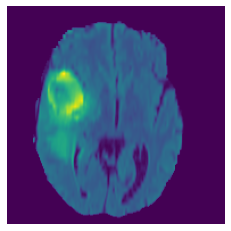

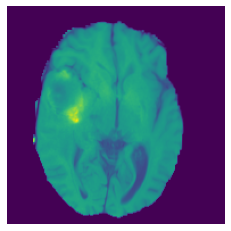

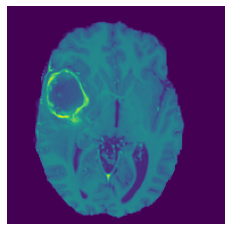

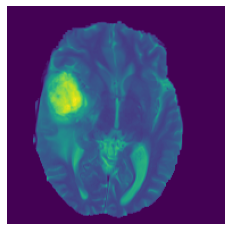

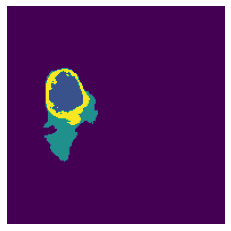

In [ ]:
display_image(data[40,:,:,0])
display_image(data[40,:,:,1])
display_image(data[40,:,:,2])
display_image(data[40,:,:,3])
display_image(gt[40,:,:,0])

In [ ]:
gt[np.where(gt==4)]=3   #converting ground truth value of 4 to 3 => one hot encoding

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(data, gt, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25,random_state=42)

In [ ]:
Y_train = to_categorical(Y_train)
Y_val = to_categorical(Y_val)
X_train = (X_train-np.mean(X_train))/np.max(X_train)
X_test = (X_test-np.mean(X_test))/np.max(X_test)
X_val = (X_val-np.mean(X_val))/np.max(X_val)

In [ ]:
X_train.shape,Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((2700, 192, 192, 4),
 (2700, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 1))

In [ ]:
X_train.shape,Y_train.shape,X_val.shape,Y_val.shape

((2700, 192, 192, 4),
 (2700, 192, 192, 4),
 (900, 192, 192, 4),
 (900, 192, 192, 4))

# UNet Model - With Additive Skip Connections


In [ ]:
def dice_coef(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection) / (K.sum(K.square(y_true),axis=-1) + K.sum(K.square(y_pred),axis=-1) + epsilon)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
#encoder

inputs = Input(shape=(192,192,4),name='input')  

block0_conv1 = Conv2D(32,3,padding='same',activation='relu',name='block0_conv1')(inputs)
block0_conv2 = Conv2D(32,3,padding='same',activation='relu',name='block0_conv2')(block0_conv1)
block0_norm = BatchNormalization(name='block0_batch_norm')(block0_conv2)
block0_pool = MaxPooling2D(name='block0_pool')(block0_norm)

block1_conv1 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv1')(block0_pool)
block1_conv2 = Conv2D(64,3,padding='same',activation='relu',name='block1_conv2')(block1_conv1)
block1_norm = BatchNormalization(name='block1_batch_norm')(block1_conv2)
block1_pool = MaxPooling2D(name='block1_pool')(block1_norm)

block2_conv1 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv1')(block1_pool)
block2_conv2 = Conv2D(128,3,padding='same',activation='relu',name='block2_conv2')(block2_conv1)
block2_norm = BatchNormalization(name='block2_batch_norm')(block2_conv2)
block2_pool = MaxPooling2D(name='block2_pool')(block2_norm)

encoder_dropout_1 = Dropout(0.2,name='encoder_dropout_1')(block2_pool)

block3_conv1 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv1')(encoder_dropout_1)
block3_conv2 = Conv2D(256,3,padding='same',activation='relu',name='block3_conv2')(block3_conv1)
block3_norm = BatchNormalization(name='block3_batch_norm')(block3_conv2)
block3_pool = MaxPooling2D(name='block3_pool')(block3_norm)

block4_conv1 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv1')(block3_pool)
block4_conv2 = Conv2D(512,3,padding='same',activation='relu',name='block4_conv2')(block4_conv1)
block4_norm = BatchNormalization(name='block4_batch_norm')(block4_conv2)
block4_pool = MaxPooling2D(name='block4_pool')(block4_norm)

block5_conv1 = Conv2D(1024,3,padding='same',activation='relu',name='block5_conv1')(block4_pool)

#decoder
up_pool1 = Conv2DTranspose(512,3,strides = (2, 2),padding='same',activation='relu',name='up_pool1')(block5_conv1)
merged_block1 = Add()([block4_norm,up_pool1])
decod_block1_conv1 = Conv2D(512,3, padding = 'same', activation='relu',name='decod_block1_conv1')(merged_block1)

up_pool2 = Conv2DTranspose(256,3,strides = (2, 2),padding='same',activation='relu',name='up_pool2')(decod_block1_conv1)
merged_block2 = Add()([block3_norm,up_pool2])
decod_block2_conv1 = Conv2D(256,3,padding = 'same',activation='relu',name='decod_block2_conv1')(merged_block2)

decoder_dropout_1 = Dropout(0.2,name='decoder_dropout_1')(decod_block2_conv1)

up_pool3 = Conv2DTranspose(128,3,strides = (2, 2),padding='same',activation='relu',name='up_pool3')(decoder_dropout_1)
merged_block3 = Add()([block2_norm,up_pool3])
decod_block3_conv1 = Conv2D(128,3,padding = 'same',activation='relu',name='decod_block3_conv1')(merged_block3)

up_pool4 = Conv2DTranspose(64,3,strides = (2, 2),padding='same',activation='relu',name='up_pool4')(decod_block3_conv1)
merged_block4 = Add()([block1_norm,up_pool4])
decod_block4_conv1 = Conv2D(64,3,padding = 'same',activation='relu',name='decod_block4_conv1')(merged_block4)

up_pool5 = Conv2DTranspose(32,3,strides = (2, 2),padding='same',activation='relu',name='up_pool5')(decod_block4_conv1)
merged_block5 = Add()([block0_norm,up_pool5])
decod_block5_conv1 = Conv2D(32,3,padding = 'same',activation='relu',name='decod_block5_conv1')(merged_block5)

pre_output = Conv2D(64,1,padding = 'same',activation='relu',name='pre_output')(decod_block5_conv1)

output = Conv2D(4,1,padding='same',activation='softmax',name='output')(pre_output)

model = Model(inputs = inputs, outputs = output)
model.summary()

In [ ]:
model.compile(optimizer=Adam(lr=1e-5),loss=dice_coef_loss,metrics=[dice_coef,'accuracy'])
model.save_weights('unet-weights.hdf5')
checkpointer = callbacks.ModelCheckpoint(filepath = 'unet-weights.hdf5',save_best_only=True)
training_log = callbacks.TensorBoard(log_dir='./Model_logs')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
history = model.fit(X_train,Y_train,validation_data=(X_val,Y_val),batch_size=8,epochs=30,callbacks=[training_log,checkpointer],shuffle=True)

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/30
338/338 [==============================] - 96s 137ms/step - loss: 0.2955 - dice_coef: 0.7045 - accuracy: 0.8825 - val_loss: 0.0342 - val_dice_coef: 0.9658 - val_accuracy: 0.9705
Epoch 2/30
338/338 [==============================] - 41s 122ms/step - loss: 0.0275 - dice_coef: 0.9725 - accuracy: 0.9727 - val_loss: 0.0297 - val_dice_coef: 0.9703 - val_accuracy: 0.9705
Epoch 3/30
338/338 [==============================] - 41s 121ms/step - loss: 0.0287 - dice_coef: 0.9713 - accuracy: 0.9714 - val_loss: 0.0295 - val_dice_coef: 0.9705 - val_accuracy: 0.9705
Epoch 4/30
338/338 [==============================] - 41s 122ms/step - loss: 0.0284 - dice_coef: 0.9716 - accuracy: 0.9716 - val_loss: 0.0295 - val_dice_coef: 0.9705 - val_accuracy: 0.9705
Epoch 5/30
338/338 [==============================] - 41s 121ms/step - loss: 0.0291 - dice_coef: 0.9709 - accuracy: 0.9709 - val_loss: 0.0295 - val_dice_coef: 0.9705 - val_accuracy: 0.9705
Epoch 6/30
338/338 [==============================] - 4

In [ ]:
a = history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainloss = a['loss']
list_testloss = a['val_loss']

plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()



In [ ]:
Y_pre = np.argmax(model.predict(X_test),axis=-1)

In [ ]:
np.unique(Y_pre)

In [ ]:
Y_pre.shape

In [ ]:
Y_pre=Y_pre.reshape(-1,192,192,1)

In [ ]:
Y_test.shape,X_test.shape

In [ ]:
for i in range(10,20):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [ ]:
Y_test_encod = to_categorical(Y_test)

In [ ]:
train_result = model.evaluate(X_train,Y_train,verbose=0)
test_result = model.evaluate(X_test,Y_test_encod,verbose=0)
val_result = model.evaluate(X_val,Y_val,verbose=0)

In [ ]:
cols = ['Loss', 'dice_coef', 'Accuracy']
rows = ['Train Result','Validation Result', 'Test Result']

cell_text = [train_result, val_result, test_result]

rcolors = plt.cm.BuPu(np.full(len(rows), 0.1))
ccolors = plt.cm.BuPu(np.full(len(cols), 0.1))

plt.figure(linewidth=4,
           facecolor= 'white'
          )

the_table = plt.table(cellText=cell_text,
                      rowLabels=rows,
                      rowColours=rcolors,
                      colColours=ccolors,
                      colLabels=cols,
                      loc='center')

the_table.scale(1.5, 2.5)

plt.suptitle('Results of HGG', fontsize=20)

ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
plt.box(on=None)

In [ ]:
Y_pre.shape

In [ ]:
for i in range(10,20):
  print('X_test '+ str(i))
  plt.imshow(X_test[i,:,:,2])
  plt.show()

  print('Predicted '+ str(i))
  plt.imshow(Y_pre[i,:,:,0])
  plt.show()

  print('Actual '+ str(i))
  plt.imshow(Y_test[i,:,:,0])
  plt.show()

In [ ]:
model.save('unet-model.h5',overwrite=True)